In [2]:
!nvidia-smi

Fri Jun 20 15:37:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
!pip install -q ultralytics roboflow

In [5]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(1)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


In [7]:
dataset.location

'/content/datasets/football-players-detection-1'

In [8]:
dataset_path = dataset.location
image_dirs = ['train/images', 'valid/images', 'test/images']
image_extensions = ('.jpg', '.jpeg', '.png')

total_images = 0
for subdir in image_dirs:
    full_path = os.path.join(dataset_path, subdir)
    if not os.path.isdir(full_path):
        continue
    for filename in os.listdir(full_path):
        if filename.lower().endswith(image_extensions):
          total_images = total_images + 1

print(f"Ukupan broj slika u datasetu: {total_images}")

Ukupan broj slika u datasetu: 663


In [9]:
!sed -i 's|train:.*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|val:.*|\1../valid/images|' {dataset.location}/data.yaml

sed: -e expression #1, char 29: invalid reference \1 on `s' command's RHS
sed: -e expression #1, char 27: invalid reference \1 on `s' command's RHS


In [10]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8l.pt data={dataset.location}/data.yaml batch=10 epochs=50 imgsz=960 plots=True

/content
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/football-players-detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

In [19]:
!ls {HOME}/runs/detect/train5/

args.yaml			 R_curve.png	      train_batch2.jpg
confusion_matrix_normalized.png  results.csv	      val_batch0_labels.jpg
confusion_matrix.png		 results.png	      val_batch0_pred.jpg
F1_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
labels_correlogram.jpg		 train_batch1.jpg     val_batch1_pred.jpg
labels.jpg			 train_batch2480.jpg  weights
P_curve.png			 train_batch2481.jpg
PR_curve.png			 train_batch2482.jpg


/content


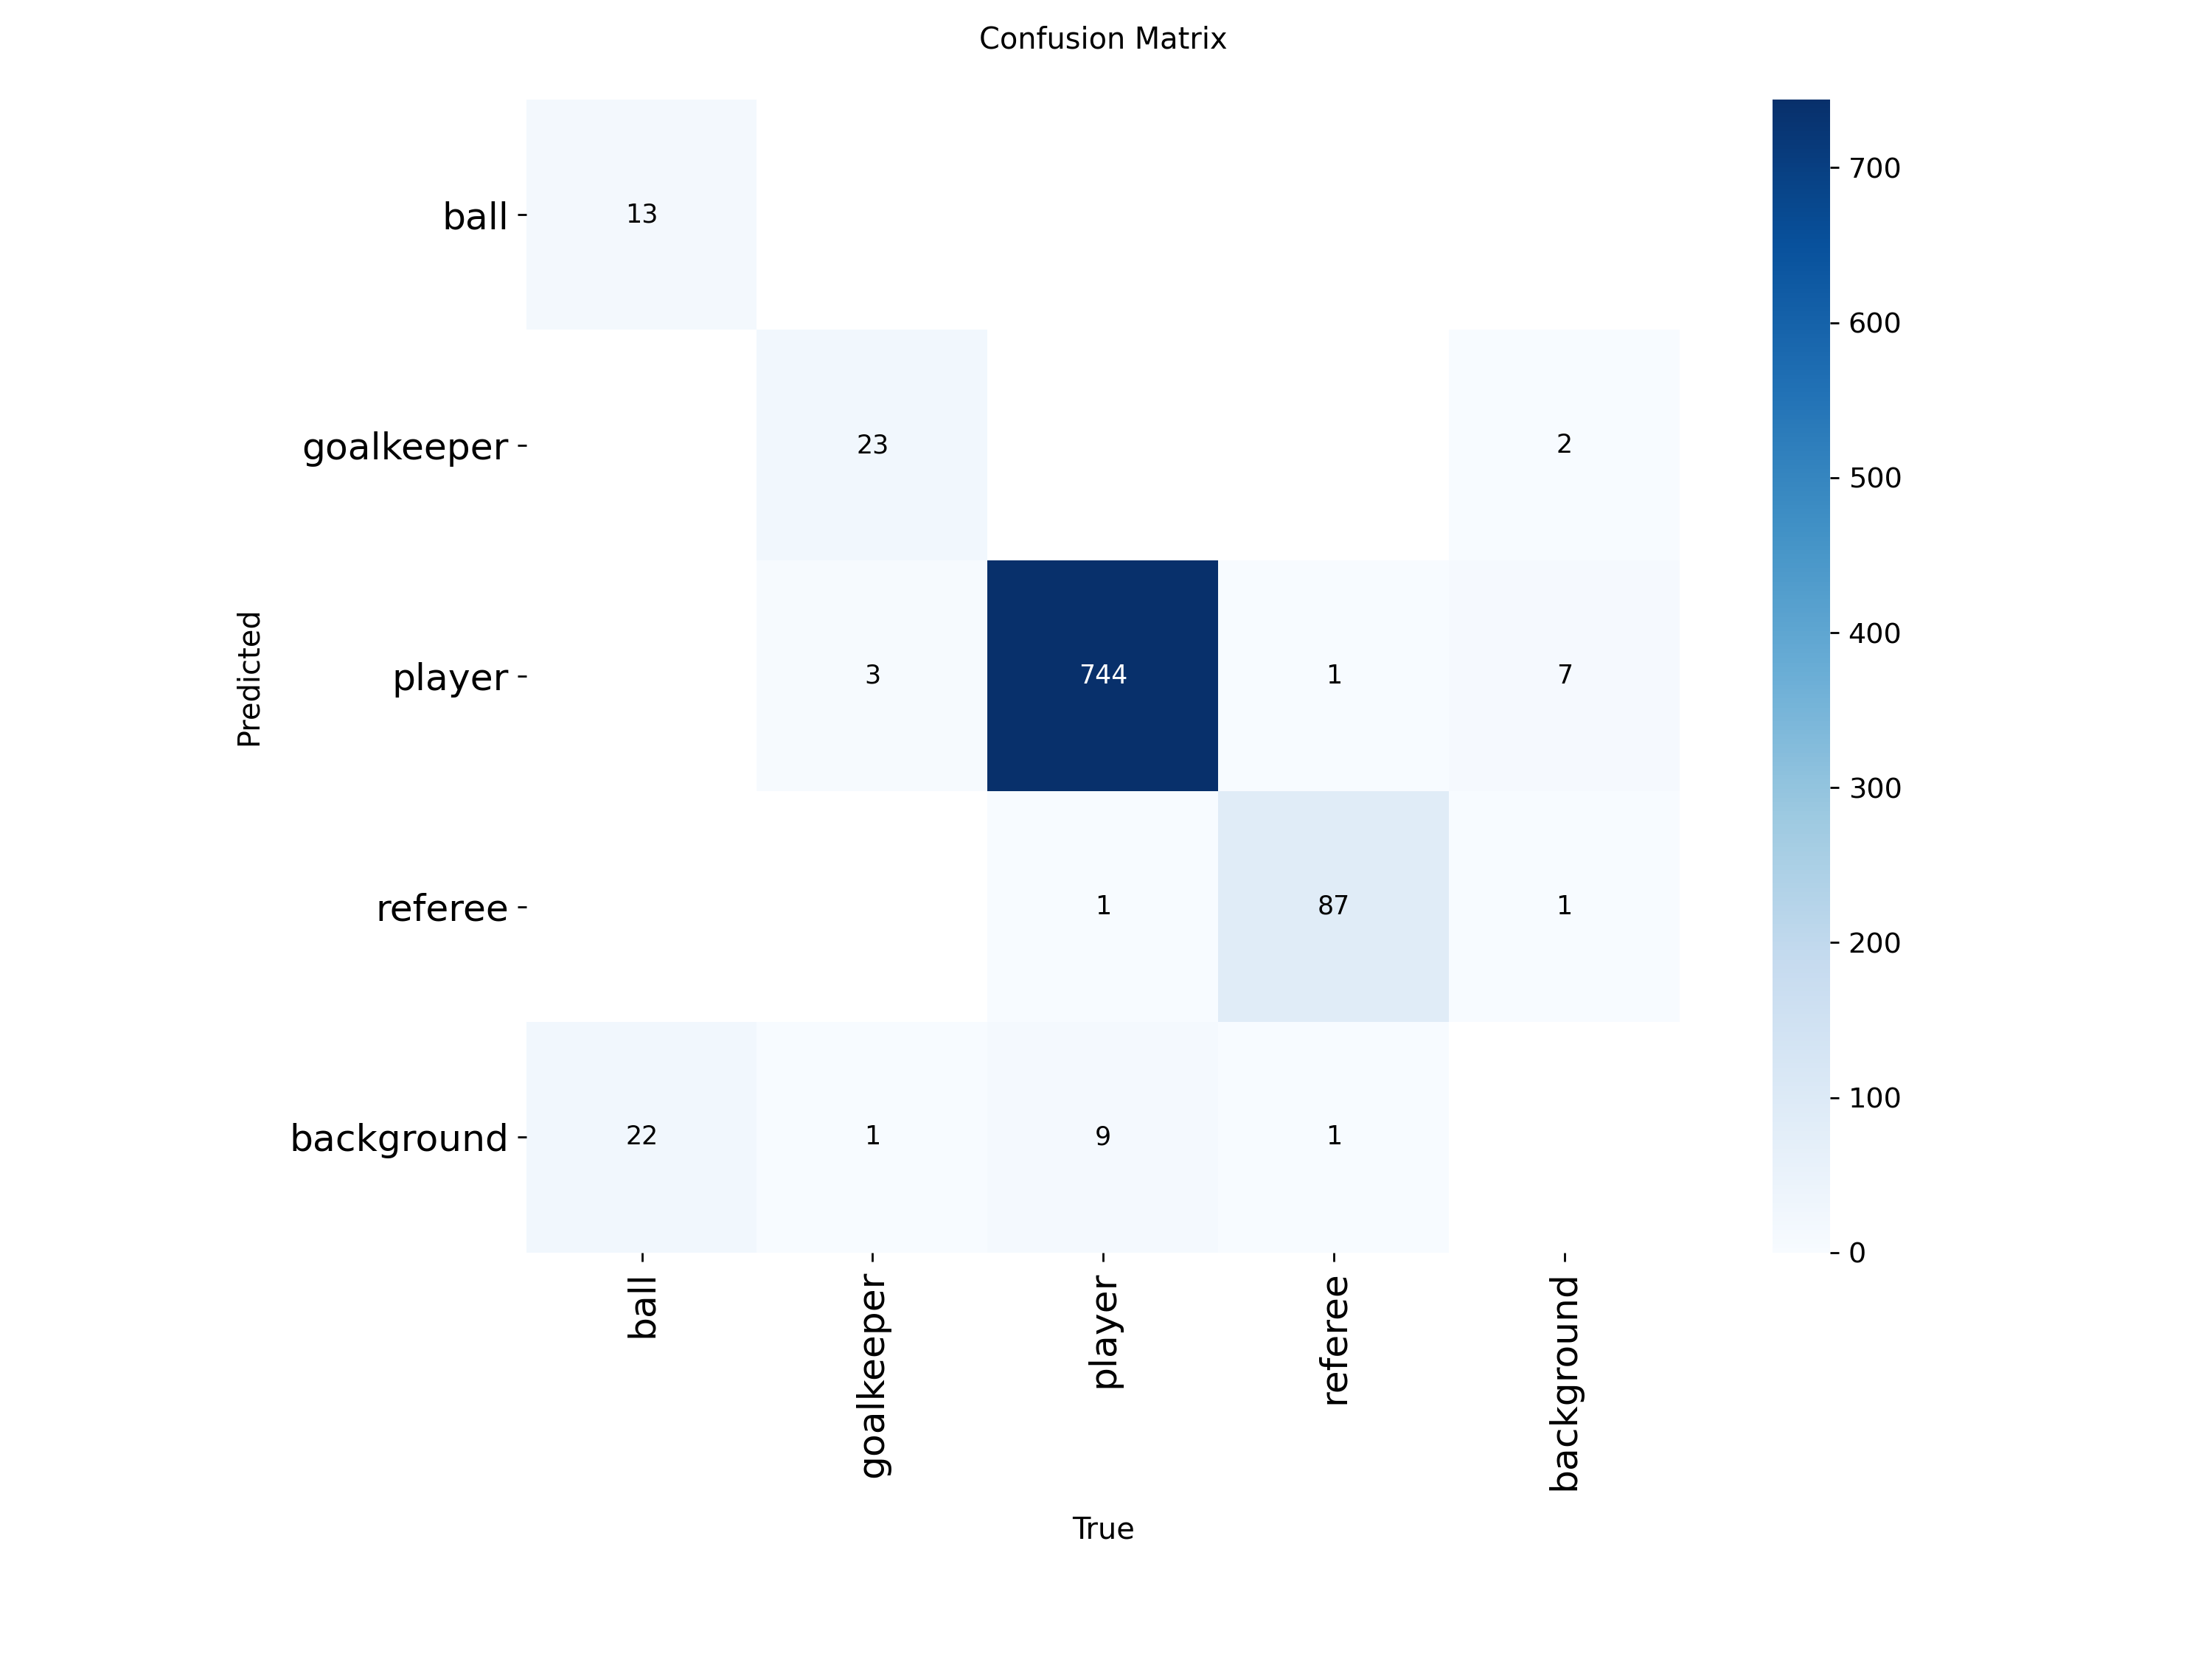

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=600)

/content


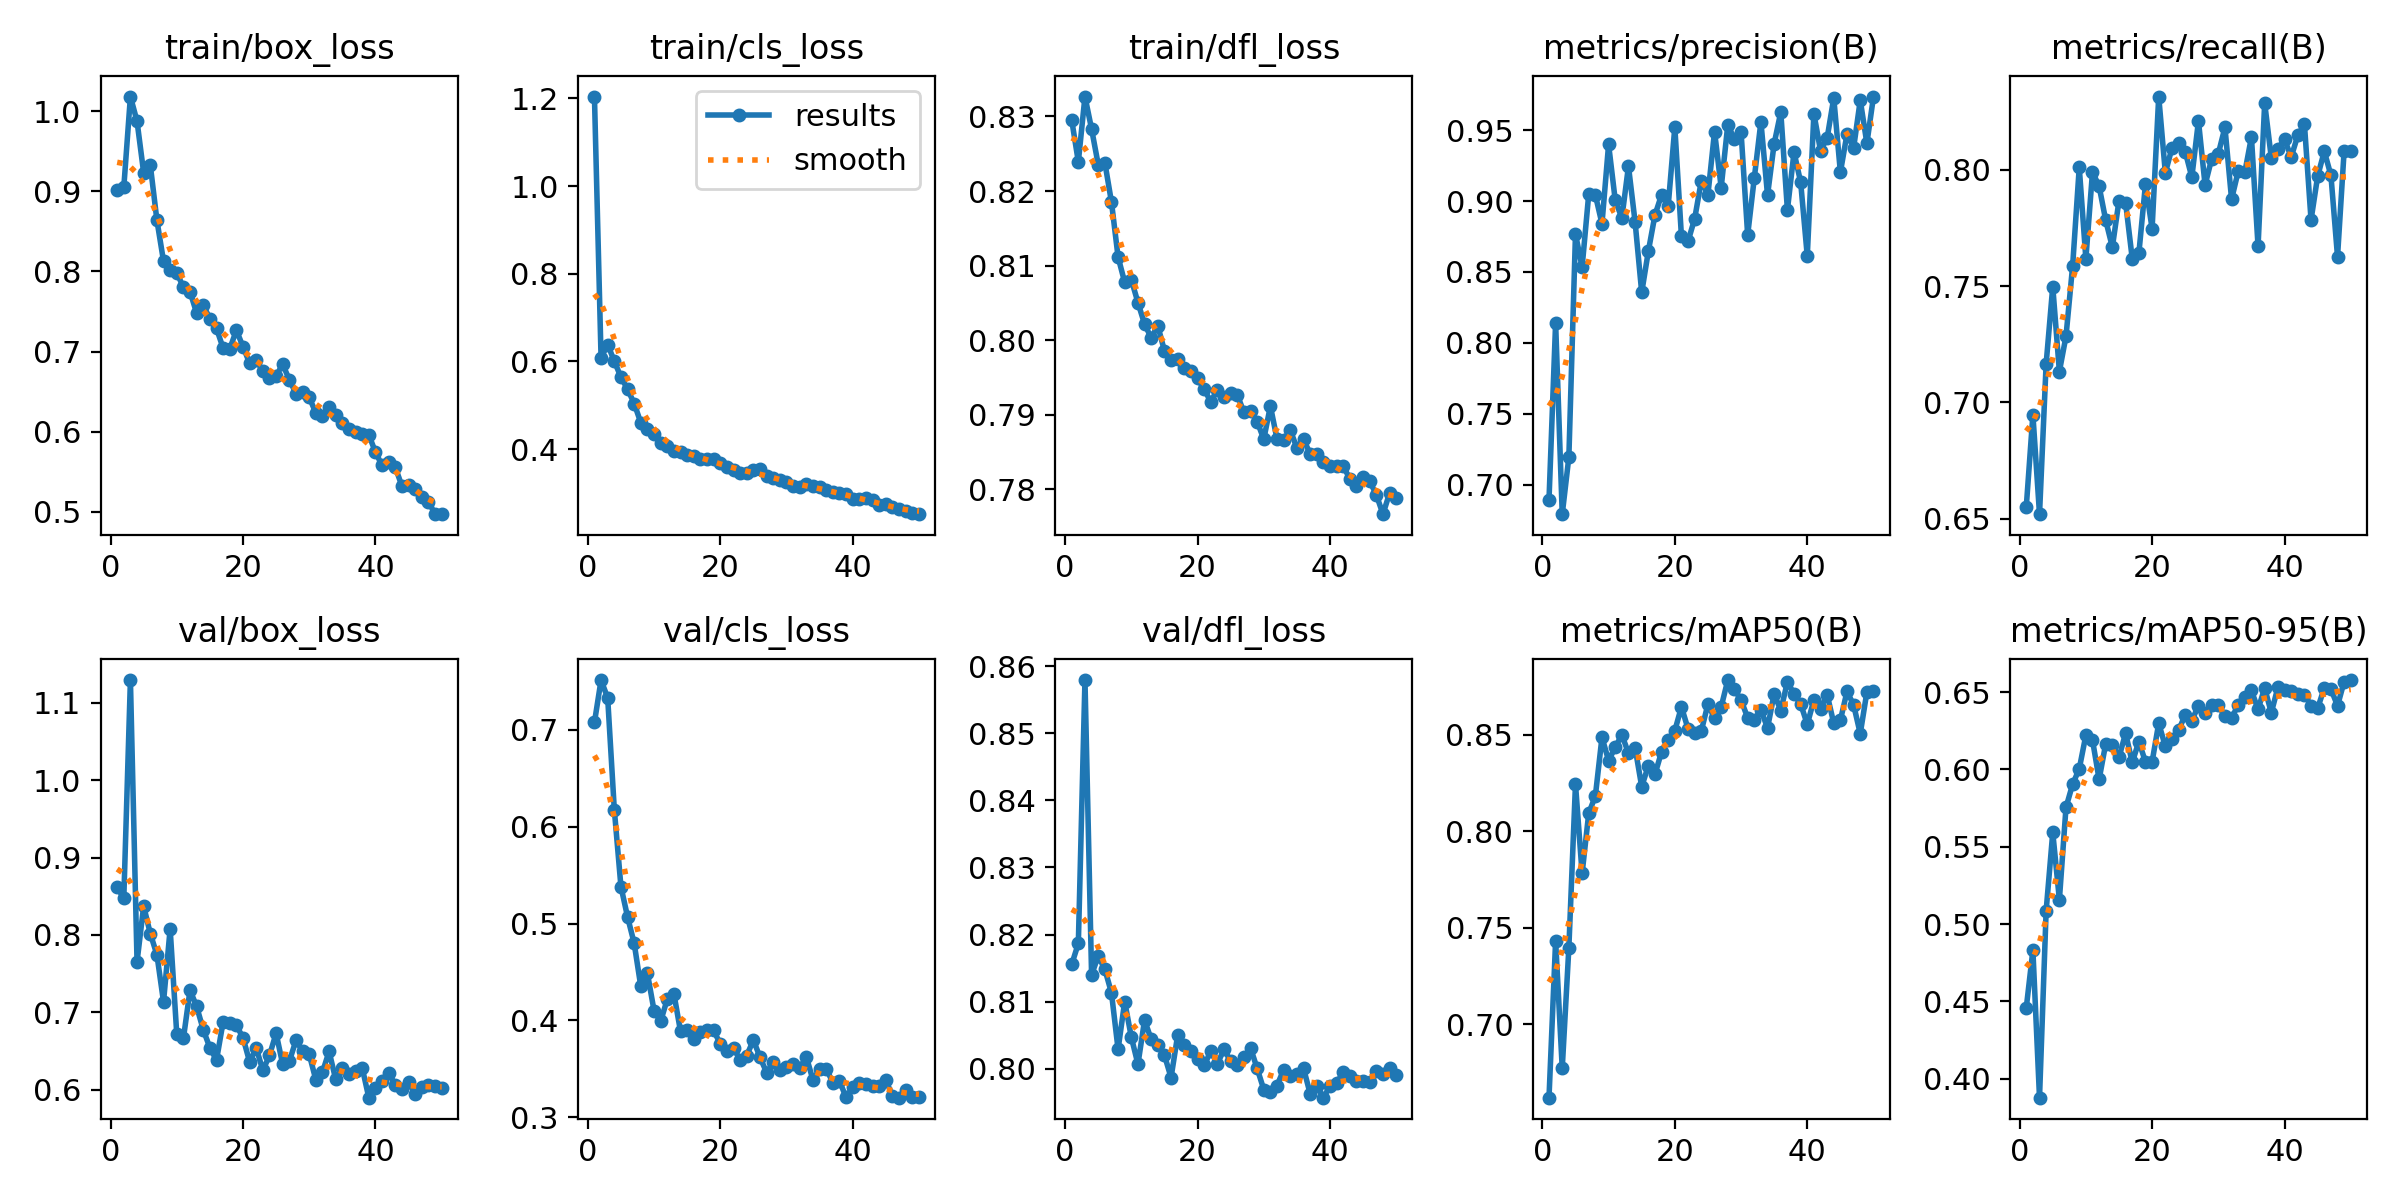

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/results.png', width=600)

/content


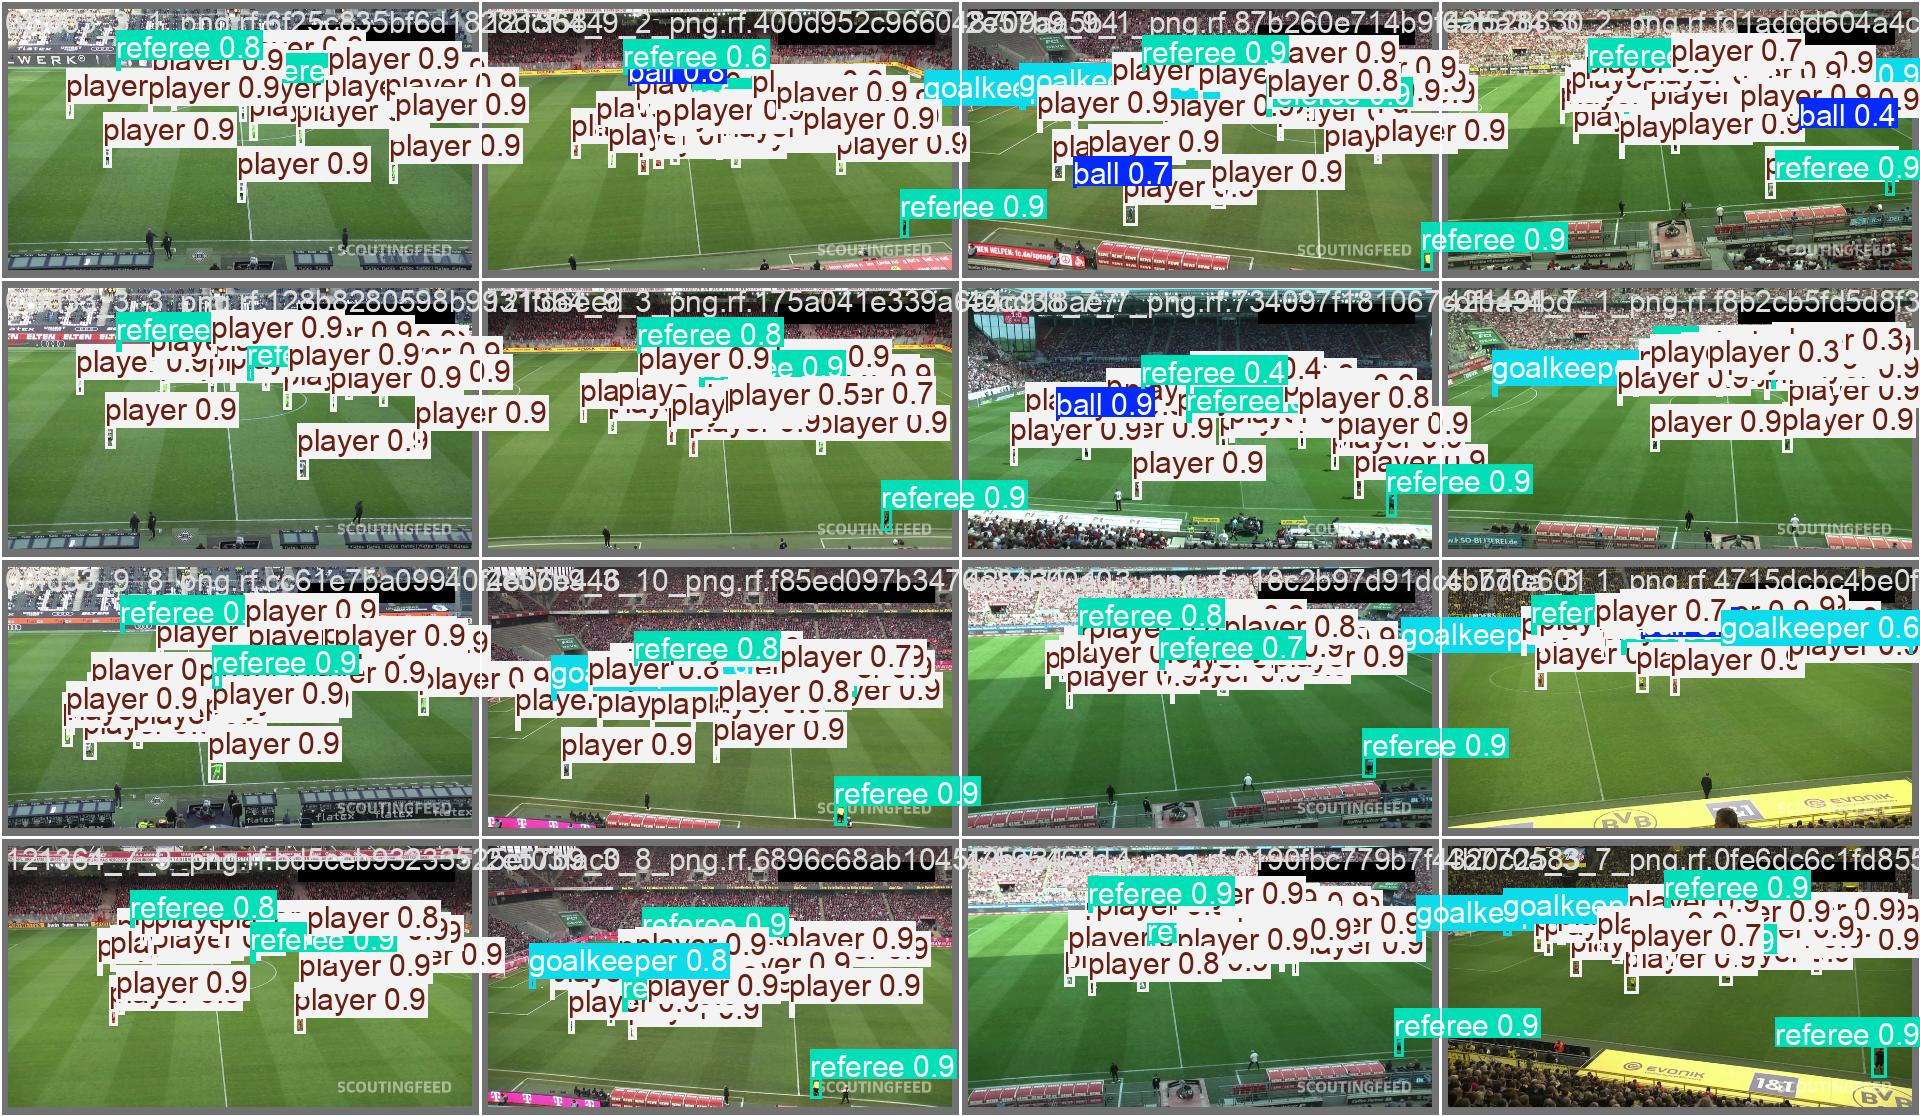

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/val_batch0_pred.jpg', width=600)

In [16]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train5/weights/best.pt data={dataset.location}/data.yaml imgsz=960

/content
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2182.6±1113.5 MB/s, size: 214.8 KB)
val: Scanning /content/datasets/football-players-detection-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.28s/it]
                   all         38        905      0.974      0.808      0.873      0.665
                  ball         35         35      0.991      0.371      0.544      0.268
            goalkeeper         27         27      0.934      0.889      0.969      0.792
                player         38        754      0.987      0.983      0.993      0.862
               referee         38         89      0.985      0.989      0.985      0.737
Speed: 0.3ms preproce

In [17]:
import pandas as pd

results_path = "runs/detect/train5/results.csv"
df = pd.read_csv(results_path)
last_epoch = df.iloc[-1]
print(last_epoch.keys())

precision = last_epoch['metrics/precision(B)']
recall = last_epoch['metrics/recall(B)']
map = last_epoch['metrics/mAP50(B)']
map_strict = last_epoch['metrics/mAP50-95(B)']

print("Rezultati zadnje epohe:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP@0.5: {map}")
print(f"mAP@0.5:0.95: {map_strict}")

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
Rezultati zadnje epohe:
Precision: 0.97362
Recall: 0.80796
mAP@0.5: 0.87261
mAP@0.5:0.95: 0.65783


In [18]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train5/weights/best.pt data={dataset.location}/data.yaml imgsz=960 split=test

/content
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2018.0±1164.3 MB/s, size: 230.9 KB)
val: Scanning /content/datasets/football-players-detection-1/test/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100% 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:01<00:00,  1.02s/it]
                   all         13        310      0.945      0.793      0.845      0.637
                  ball         11         11      0.942      0.273      0.457      0.203
            goalkeeper         11         11      0.915      0.986      0.965      0.798
                player         13        259      0.968      0.981      0.991      0.856
               referee         13         29      0.953      0.931      0.966      0.693
Speed: 0.5ms preproces